In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('/content/Covid_stats_Jan2025.csv', encoding='latin1')
df.head().style.set_properties(**{"background-color": "#c46525","color":"#A8DADC","border": "1.5px solid Yellow"})

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",TotÿCases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop,Population,Continent,1 Caseevery X ppl,1 Deathevery X ppl,1 Testevery X ppl,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,USA,"111,820,082",nan,"1,219,487",nan,"109,814,428",nan,"786,167",940,"333,985","3,642","1,186,851,502","3,544,901","334,805,269",North America,3,275,0.000000,nan,nan,"2,348"
1,India,"45,035,393",nan,"533,570",nan,nan,nan,nan,nan,"32,016",379,"935,879,495","665,334","1,406,631,776",Asia,31,"2,636",2.000000,nan,nan,0.4
2,France,"40,138,560",nan,"167,642",nan,"39,970,918",nan,0,nan,"612,013","2,556","271,490,188","4,139,547","65,584,518",Europe,2,391,0.000000,nan,nan,nan
3,Germany,"38,828,995",nan,"183,027",nan,"38,240,600",nan,"405,368",nan,"462,891","2,182","122,332,384","1,458,359","83,883,596",Europe,2,458,1.000000,nan,nan,"4,833"
4,Brazil,"38,743,918",nan,"711,380",nan,"36,249,161",nan,"1,783,377",nan,"179,908","3,303","63,776,166","296,146","215,353,593",South America,6,303,3.000000,nan,nan,"8,281"


In [5]:
df_copy = df.copy()  # Create a copy to avoid modifying the original data

In [6]:
df_copy.rename(columns={
    'Country,Other': 'Country',
    'TotÿCases/1M pop': 'Cases_per_1M',
    'Deaths/1M pop': 'Deaths_per_1M',
    'Tests/\n1M pop': 'Tests_per_1M',
    '1 Caseevery X ppl': 'Case_every_X_ppl',
    '1 Deathevery X ppl': 'Death_every_X_ppl',
    '1 Testevery X ppl': '1_Testevery_X_ppl',
    'New Cases/1M pop': 'New_Cases_per_1M',
    'New Deaths/1M pop': 'New_Deaths_per_1M',
    'Active Cases/1M pop': 'Active_Cases_per_1M'
}, inplace=True)
numerical_cols = df_copy.select_dtypes(include=np.number).columns
df_copy[numerical_cols] = df_copy[numerical_cols].fillna(0)

In [7]:
cols_to_numeric = ['TotalCases', 'TotalDeaths', 'TotalRecovered', 'ActiveCases',
                   'Serious,Critical', 'Cases_per_1M', 'Deaths_per_1M',
                   'TotalTests', 'Tests_per_1M', 'Population',
                   'Case_every_X_ppl', 'Death_every_X_ppl', '1_Testevery_X_ppl',
                   'New_Cases_per_1M', 'New_Deaths_per_1M', 'Active_Cases_per_1M']
analysis_results = {}
for col in cols_to_numeric:
    df_copy[col] = df_copy[col].astype(str).str.replace(',', '', regex=False)
    df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')  # Convert and coerce errors to NaN
    df_copy[col] = df_copy[col].fillna(0) # fill any new NaNs from conversion

In [8]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              231 non-null    object 
 1   TotalCases           231 non-null    int64  
 2   NewCases             231 non-null    float64
 3   TotalDeaths          231 non-null    float64
 4   NewDeaths            231 non-null    float64
 5   TotalRecovered       231 non-null    float64
 6   NewRecovered         231 non-null    float64
 7   ActiveCases          231 non-null    float64
 8   Serious,Critical     231 non-null    float64
 9   Cases_per_1M         231 non-null    float64
 10  Deaths_per_1M        231 non-null    float64
 11  TotalTests           231 non-null    float64
 12  Tests_per_1M         231 non-null    float64
 13  Population           231 non-null    float64
 14  Continent            228 non-null    object 
 15  Case_every_X_ppl     231 non-null    flo

In [9]:
df_copy.describe().style.background_gradient(cmap='tab20c')

,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Cases_per_1M,Deaths_per_1M,TotalTests,Tests_per_1M,Population,Case_every_X_ppl,Death_every_X_ppl,1_Testevery_X_ppl,New_Cases_per_1M,New_Deaths_per_1M,Active_Cases_per_1M
count,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000
mean,6099586.484848,0.000000,60675.714286,0.000000,5349820.017316,6.987013,121732.181818,163.077922,201583.006061,1242.516883,29725131.225108,1987501.415584,28123219.614719,385.575758,12767.251082,9.813853,0.000000,0.000000,29283.599481
std,47242731.438876,0.000000,472073.112854,0.000000,45236680.325368,62.223963,1461417.482720,2289.560454,205823.113535,1306.514039,115130855.565780,3550142.795249,101662460.651895,4126.130220,53550.261905,25.835516,0.000000,0.000000,91717.162118
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-168.580000
25%,26366.000000,0.000000,185.500000,0.000000,2189.500000,0.000000,0.000000,0.000000,18412.500000,139.500000,216878.000000,78031.000000,406353.000000,3.000000,457.000000,0.000000,0.000000,0.000000,16.500000
50%,206897.000000,0.000000,1974.000000,0.000000,58947.000000,0.000000,127.000000,0.000000,128681.000000,788.000000,1660662.000000,717380.000000,5511370.000000,7.000000,1068.000000,1.000000,0.000000,0.000000,323.000000
75%,1377176.000000,0.000000,14688.000000,0.000000,1042623.500000,0.000000,2288.500000,0.000000,328620.500000,2040.000000,11623027.500000,2126400.500000,21524803.000000,45.500000,5522.500000,4.500000,0.000000,0.000000,3258.000000
max,704753890.000000,0.000000,7010681.000000,0.000000,675619811.000000,790.000000,22123398.000000,34794.000000,771655.000000,6595.000000,1186851502.000000,23302116.000000,1406631776.000000,62616.000000,626161.000000,196.000000,0.000000,0.000000,612553.000000


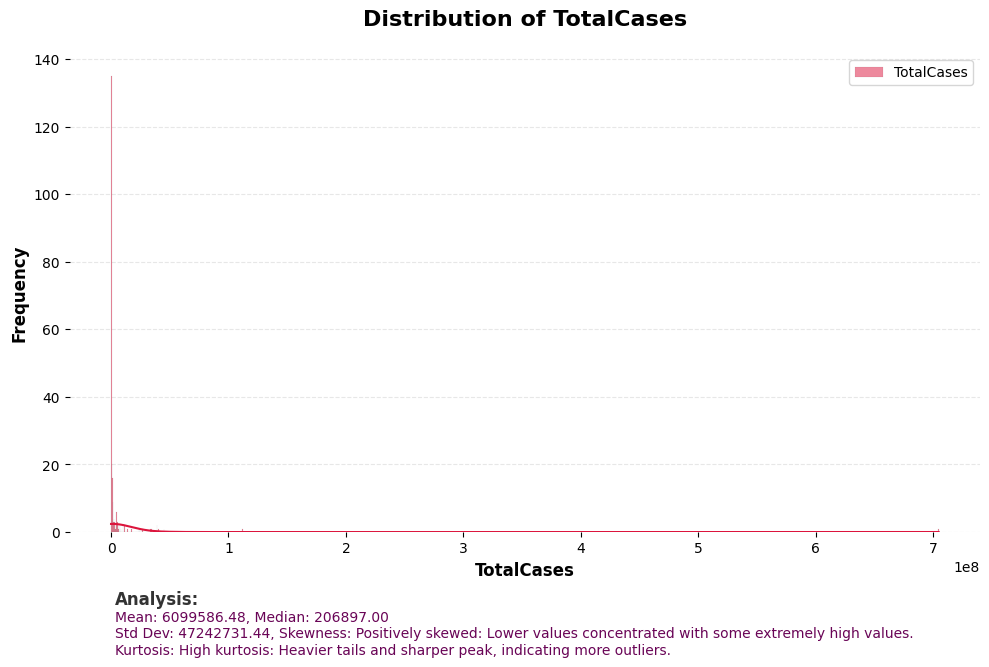

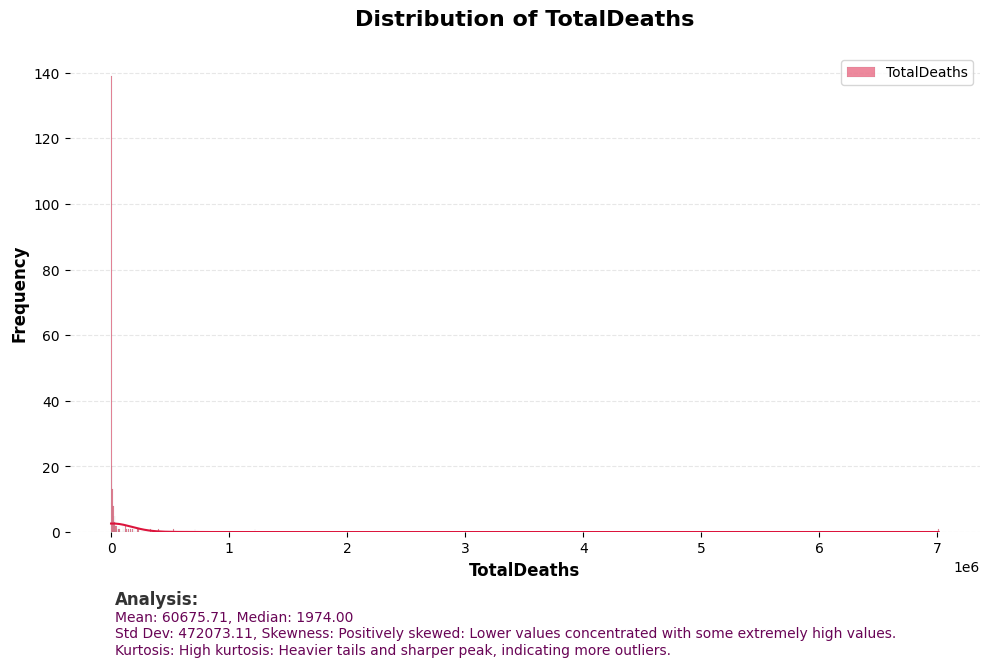

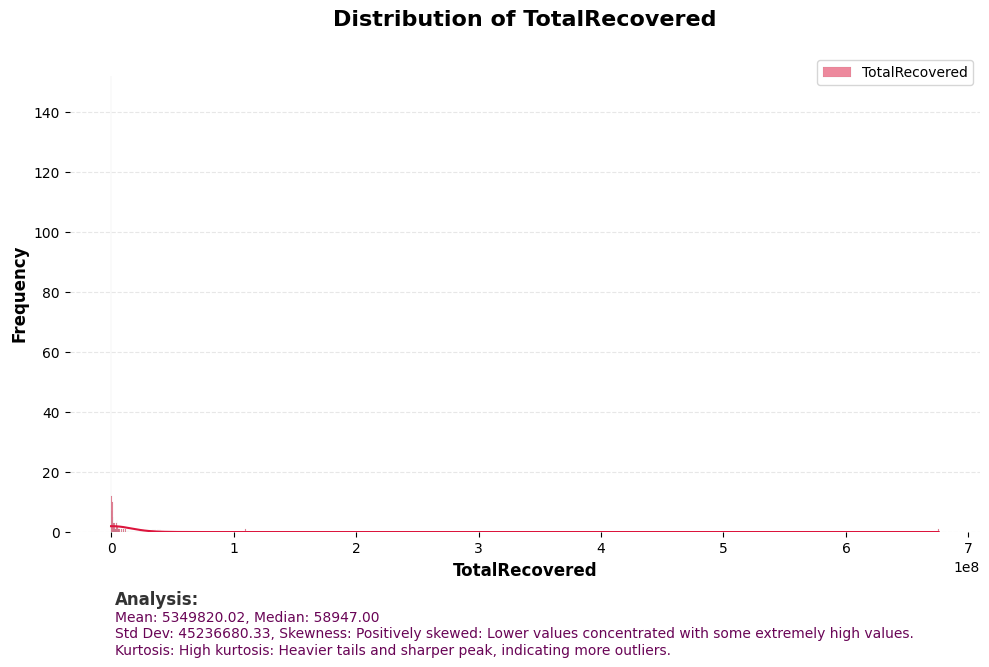

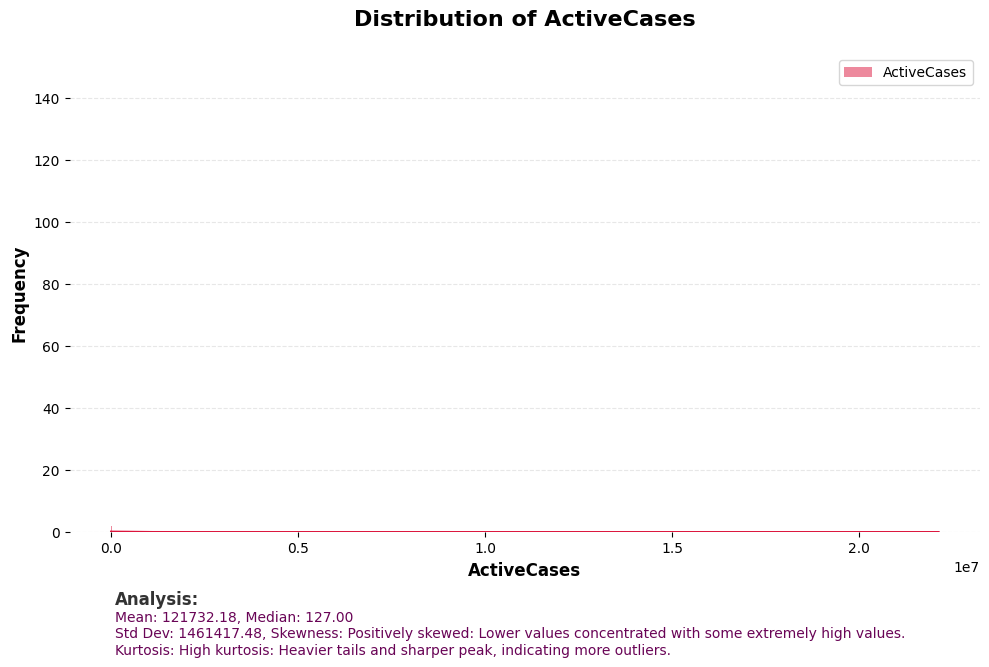

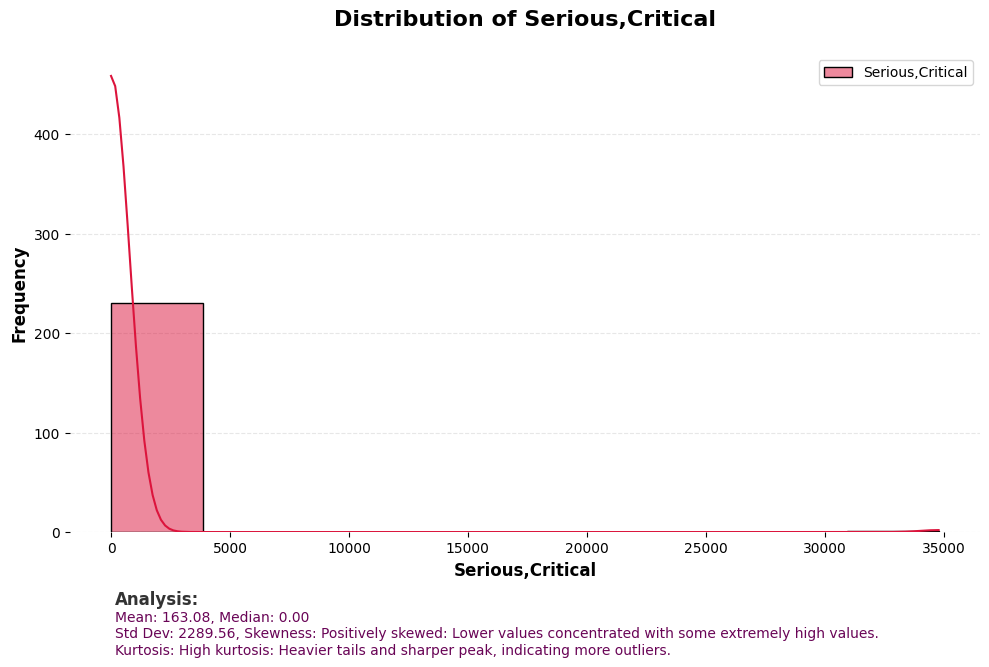

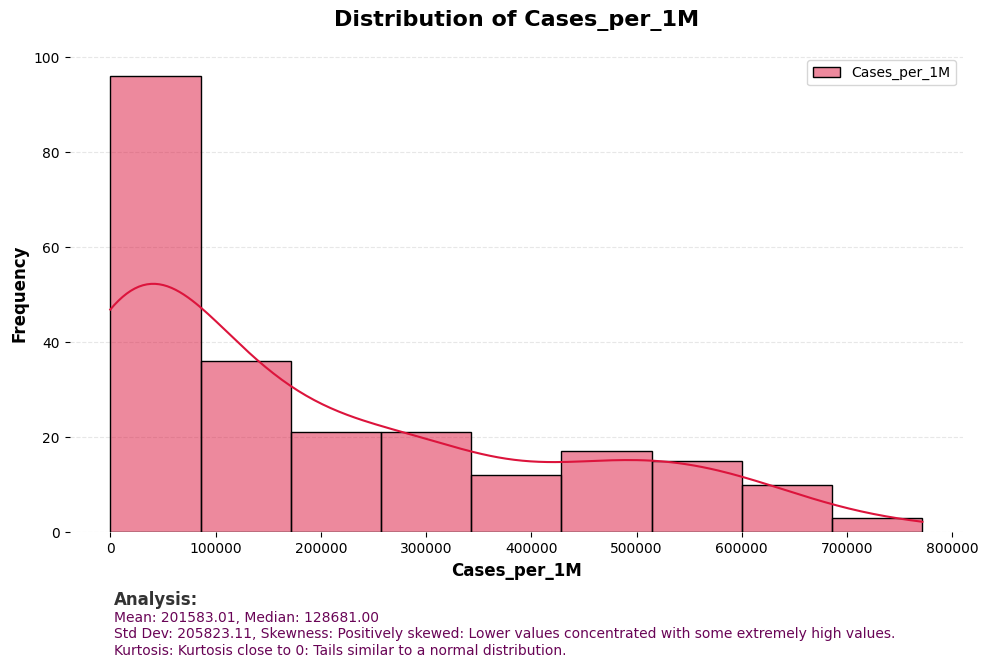

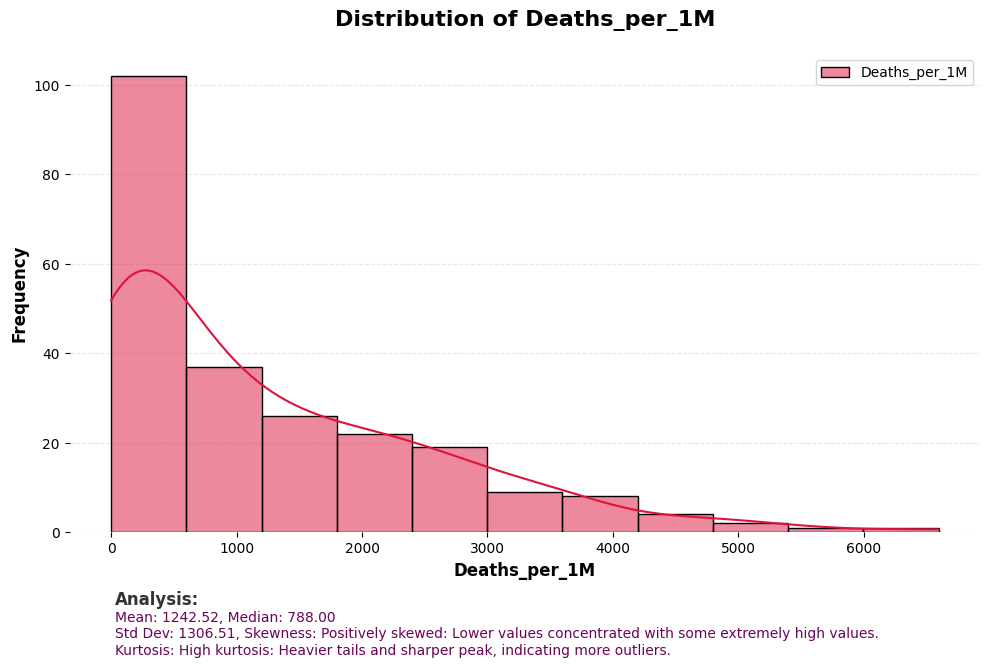

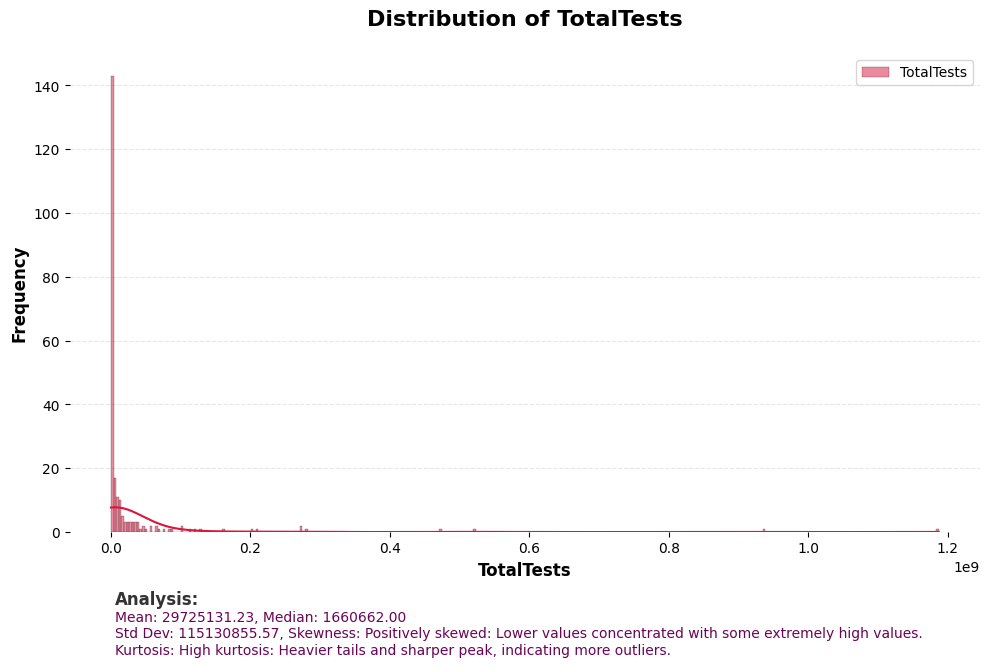

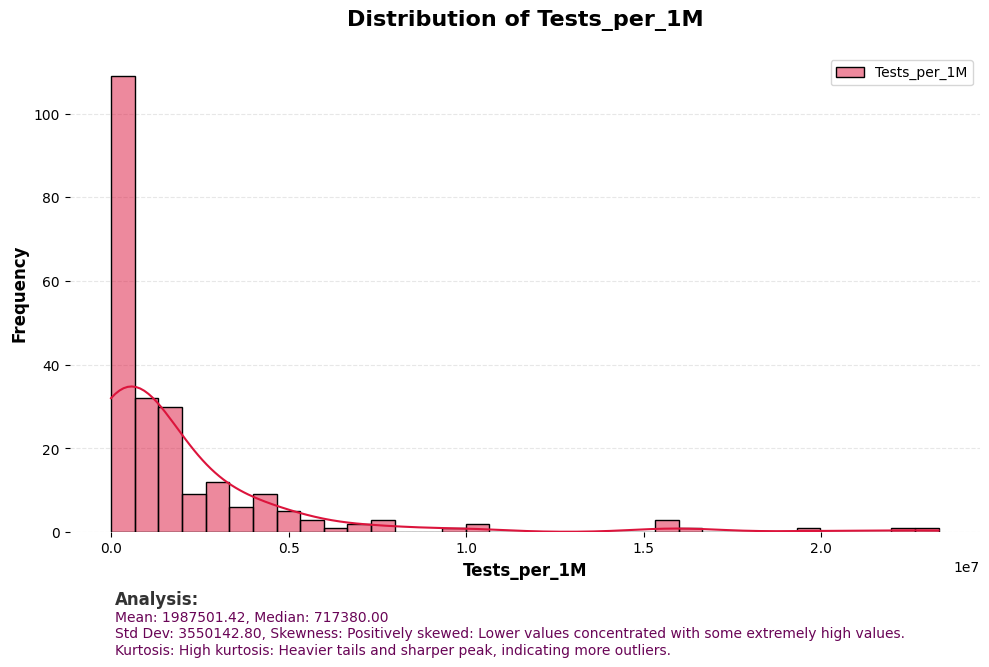

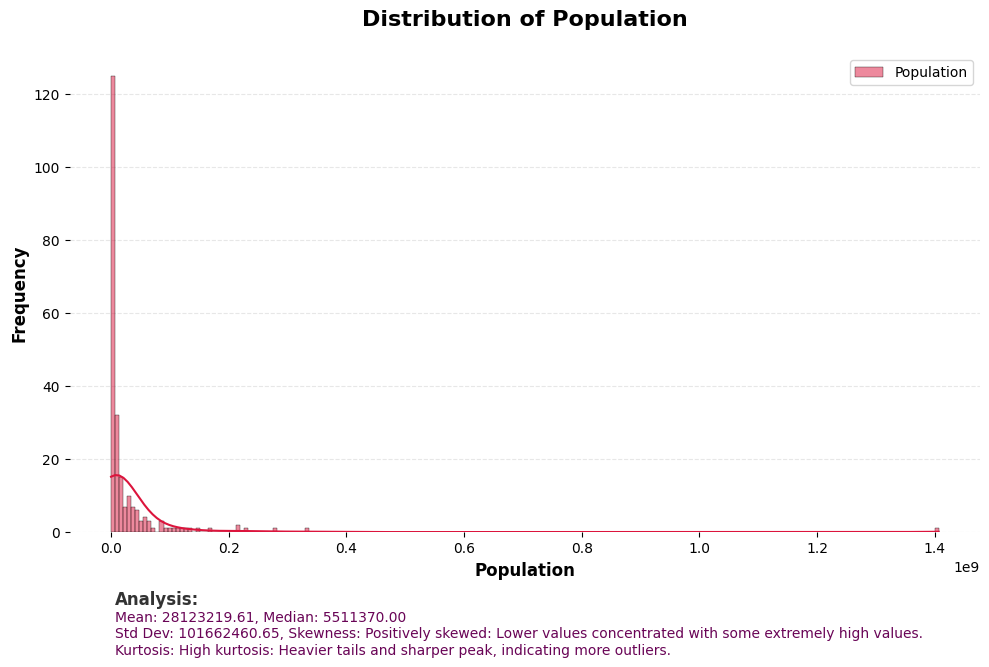

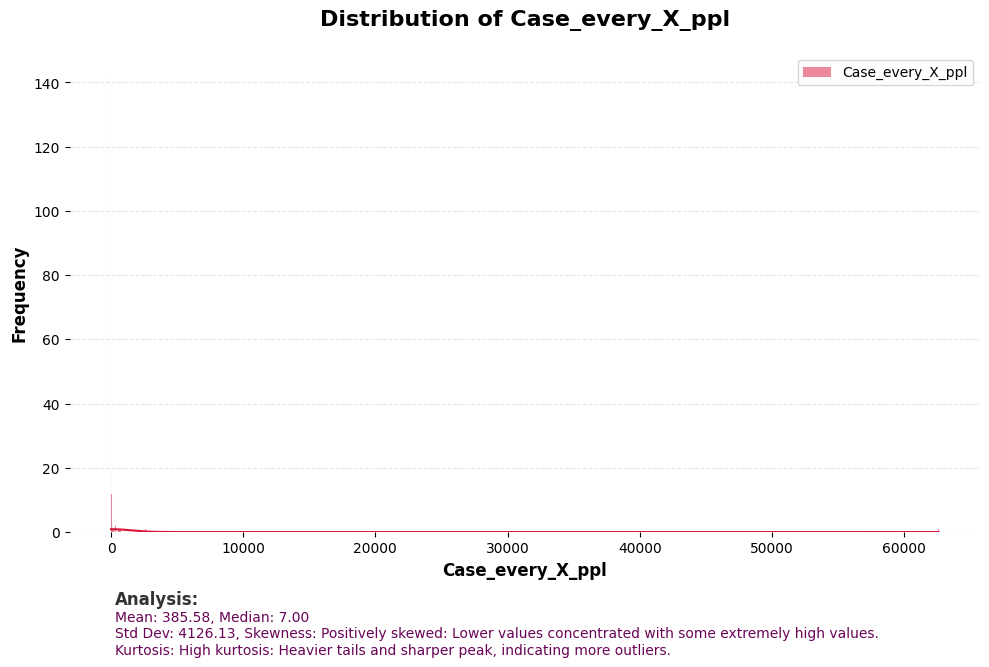

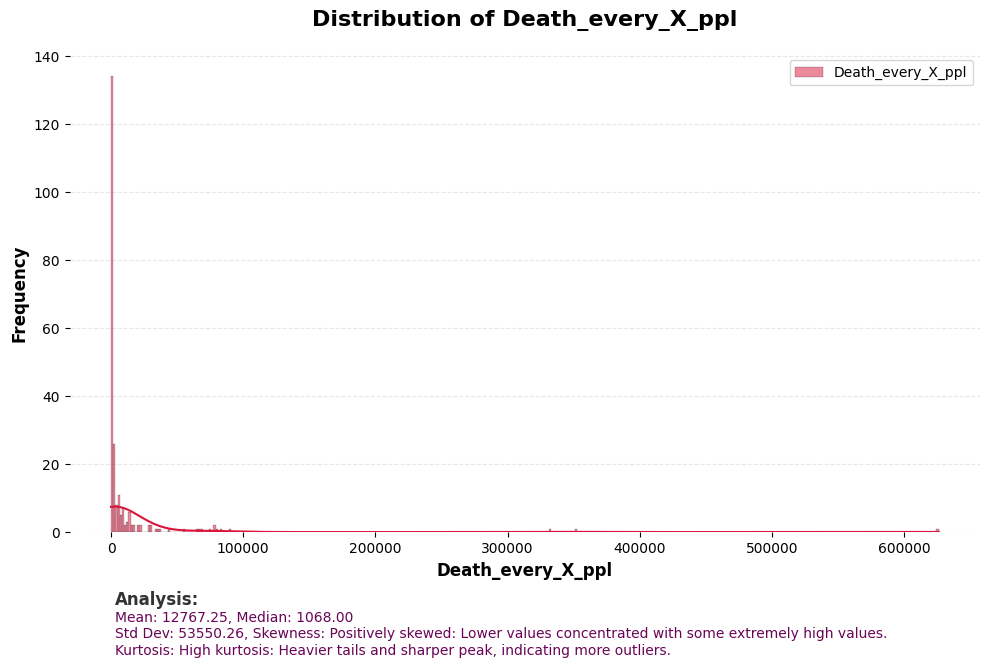

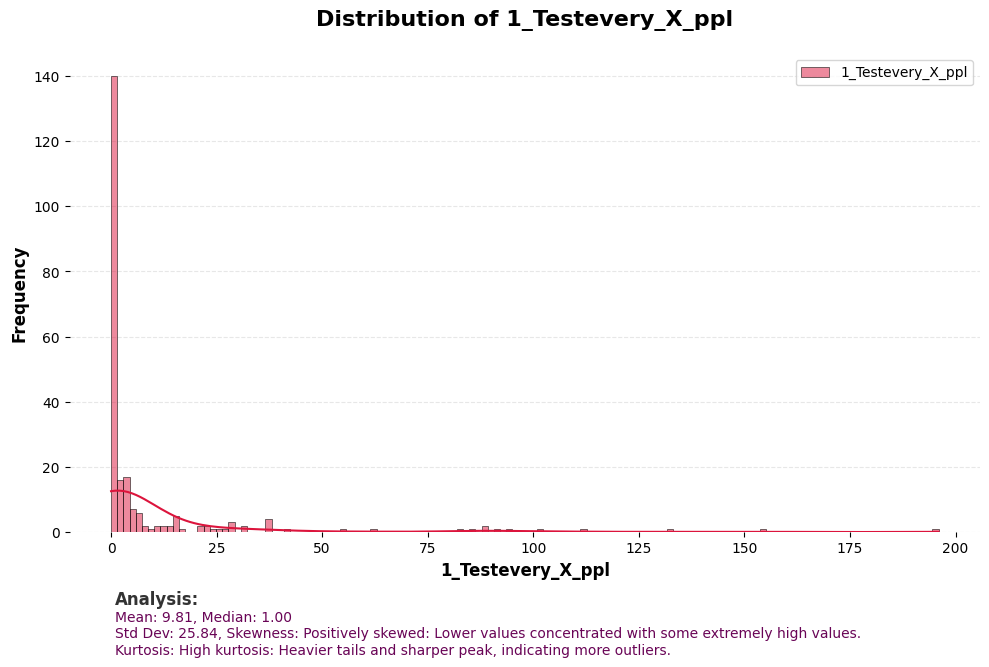

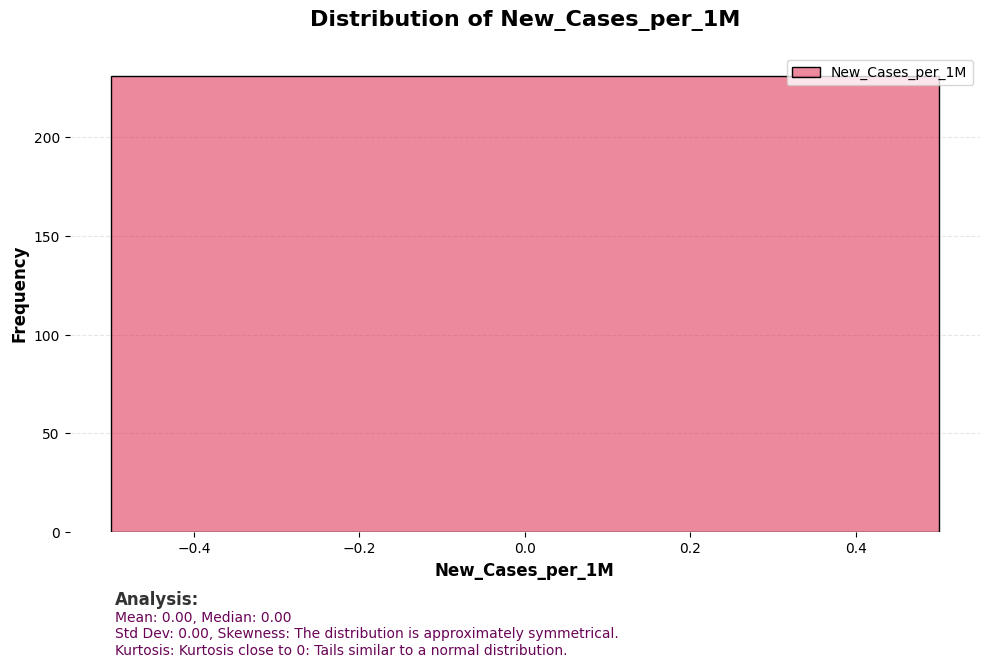

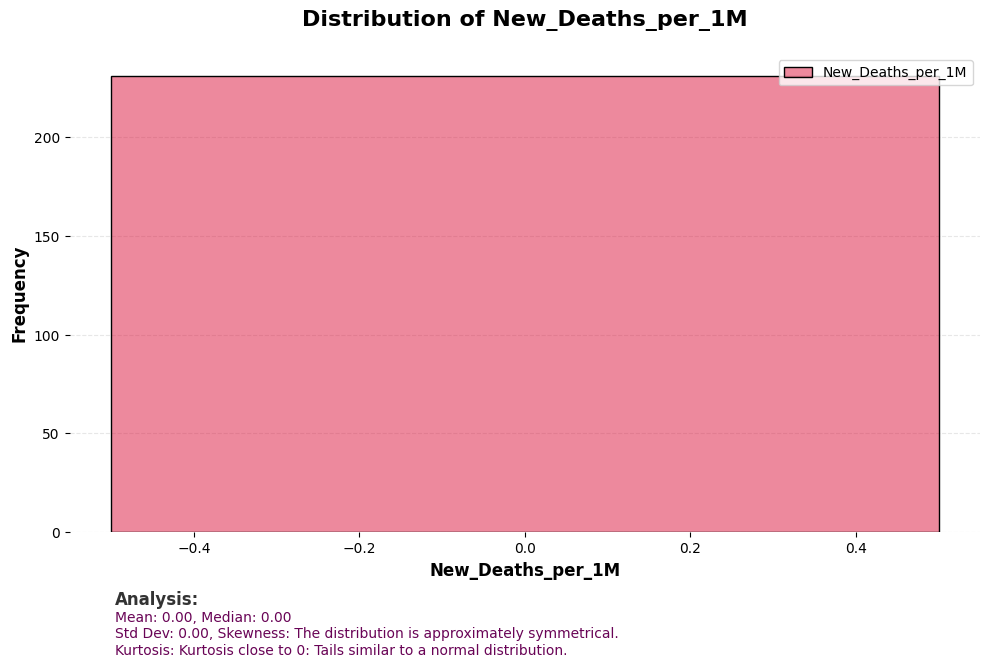

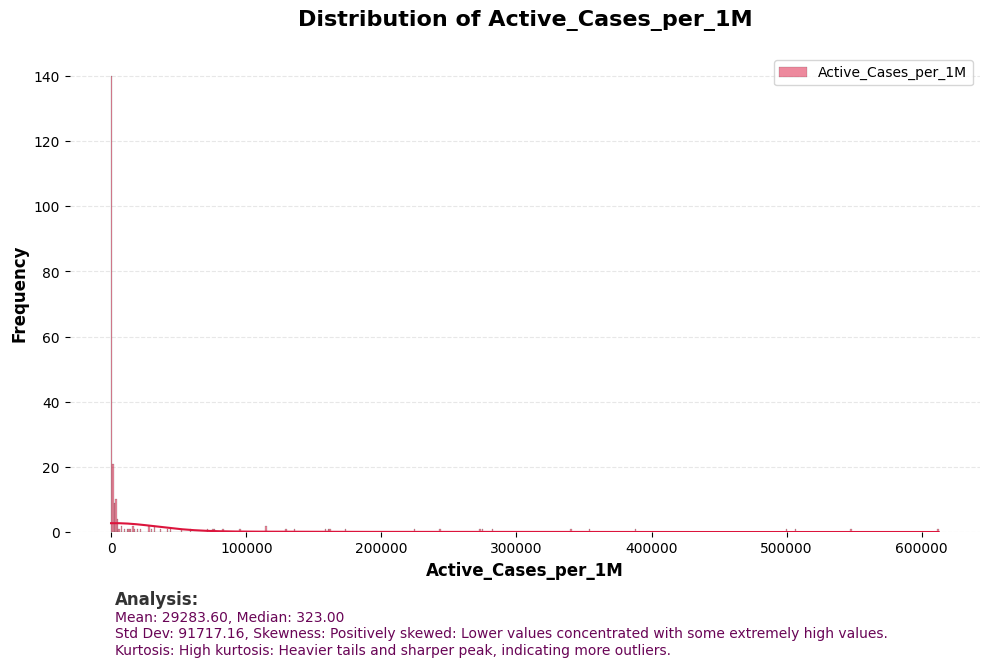

In [10]:
plt.style.use('default')
colors = ['#DC143C', '#696969', '#A9A9A9', '#D3D3D3']
def create_histogram(data, column, specific_analysis, title, xlabel, ylabel, color=colors[0]):
    """
    Creates a histogram for a given column with specified title and labels.
    """
    fig, ax = plt.subplots(figsize=(10, 7.5))  # Increased figure height
    fig.patch.set_facecolor('white')
    sns.histplot(data[column], kde=True, color=color, ax=ax, label=column)  # Added KDE for smoother visualization
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.legend(loc='upper right', fontsize=10)  # Add legend
    fig.text(0.05, -0.15, 'Analysis:', fontsize=12, fontweight='bold', color='#333', transform=ax.transAxes)  # Analysis text
    fig.text(0.05, -0.25, specific_analysis, fontsize=10, color='#690456', wrap=True, transform=ax.transAxes)  # Add specific analysis #666
    plt.tight_layout(rect=[0, 0.15, 1, 0.95])  # Adjusted bottom and top margins for text
    plt.show()
def analyze_distribution(data, column):
    """
    Provides a brief textual analysis of the distribution.
    """
    mean_val = data[column].mean()
    median_val = data[column].median()
    std_val = data[column].std()
    skew_val = data[column].skew()
    kurt_val = data[column].kurtosis()
    skew_interpretation = "The distribution is approximately symmetrical."
    if skew_val > 0.5:
        skew_interpretation = "Positively skewed: Lower values concentrated with some extremely high values."
    elif skew_val < -0.5:
        skew_interpretation = "Negatively skewed: Higher values concentrated with some extremely low values."
    kurtosis_interpretation = "Kurtosis close to 0: Tails similar to a normal distribution."
    if kurt_val > 1:
        kurtosis_interpretation = "High kurtosis: Heavier tails and sharper peak, indicating more outliers."
    elif kurt_val < -1:
        kurtosis_interpretation = "Low kurtosis: Lighter tails and flatter peak."
    specific_analysis = (
        f"Mean: {mean_val:.2f}, Median: {median_val:.2f}\n"
        f"Std Dev: {std_val:.2f}, Skewness: {skew_interpretation}\n"
        f"Kurtosis: {kurtosis_interpretation}"
    )
    analysis_results[column] = specific_analysis # store analysis in dictionary
    print("")
columns_to_analyze = ['TotalCases', 'TotalDeaths', 'TotalRecovered', 'ActiveCases',
                   'Serious,Critical', 'Cases_per_1M', 'Deaths_per_1M',
                   'TotalTests', 'Tests_per_1M', 'Population',
                   'Case_every_X_ppl', 'Death_every_X_ppl', '1_Testevery_X_ppl',
                   'New_Cases_per_1M', 'New_Deaths_per_1M', 'Active_Cases_per_1M']
for col in columns_to_analyze:
    analyze_distribution(df_copy, col)
    create_histogram(df_copy, col, analysis_results[col], f'Distribution of {col}', col, 'Frequency')

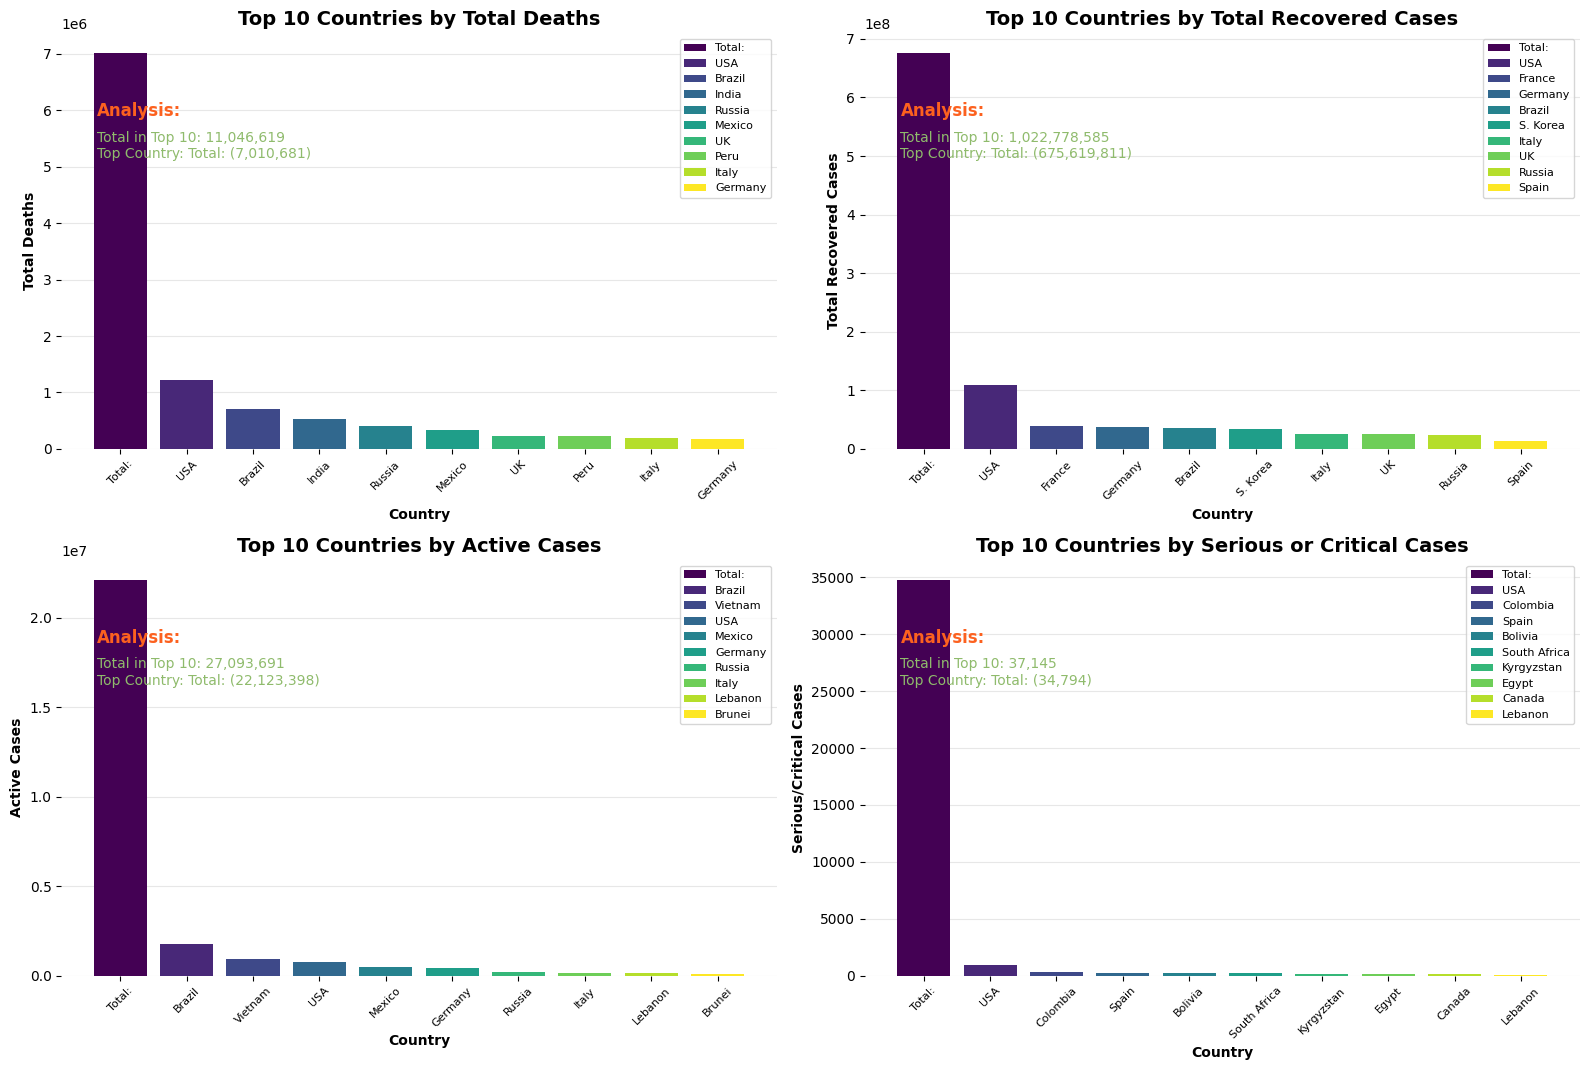

In [11]:
cols_to_numeric = ['TotalCases', 'TotalDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical']
for col in cols_to_numeric:
    df_copy[col] = df_copy[col].astype(str).str.replace(',', '', regex=False)
    df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce').fillna(0) # Convert and coerce errors to NaN
plt.style.use('default')
colors = plt.cm.get_cmap('viridis', 10).colors # 'viridis' is a good default.  get_cmap creates distinct colors
metrics = ['TotalDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical']
metric_titles = {
    'TotalDeaths': 'Top 10 Countries by Total Deaths',
    'TotalRecovered': 'Top 10 Countries by Total Recovered Cases',
    'ActiveCases': 'Top 10 Countries by Active Cases',
    'Serious,Critical': 'Top 10 Countries by Serious or Critical Cases'
}
metric_ylabels = {
    'TotalDeaths': 'Total Deaths',
    'TotalRecovered': 'Total Recovered Cases',
    'ActiveCases': 'Active Cases',
    'Serious,Critical': 'Serious/Critical Cases'
}
fig, axes = plt.subplots(2, 2, figsize=(16, 12)) # Create subplots
fig.patch.set_facecolor('white') # Set figure background
axes = axes.flatten() # Flatten the 2x2 array of axes for easier iteration
for i, metric in enumerate(metrics):
    top_10 = df_copy.nlargest(10, metric)
    ax = axes[i]
    bars = ax.bar(top_10['Country'], top_10[metric], color=colors)  # Capture the bar objects
    ax.set_title(metric_titles[metric], fontsize=14, fontweight='bold')
    ax.set_xlabel('Country', fontsize=10, fontweight='bold')
    ax.set_ylabel(metric_ylabels[metric], fontsize=10, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.grid(axis='y', alpha=0.3)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.legend(bars, top_10['Country'], loc='upper right', fontsize=8)  # Add legend
    total = top_10[metric].sum()
    top_country = top_10['Country'].iloc[0]
    top_value = top_10[metric].iloc[0]
    analysis_text = (
        f"Total in Top 10: {total:,.0f}\n"
        f"Top Country: {top_country} ({top_value:,.0f})"
    )
    ax.text(0.05, 0.80, 'Analysis:', fontsize=12, fontweight='bold', color='#fc611f', transform=ax.transAxes)
    ax.text(0.05, 0.70, analysis_text, fontsize=10, color='#8fbb6c', transform=ax.transAxes)
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout
plt.show()

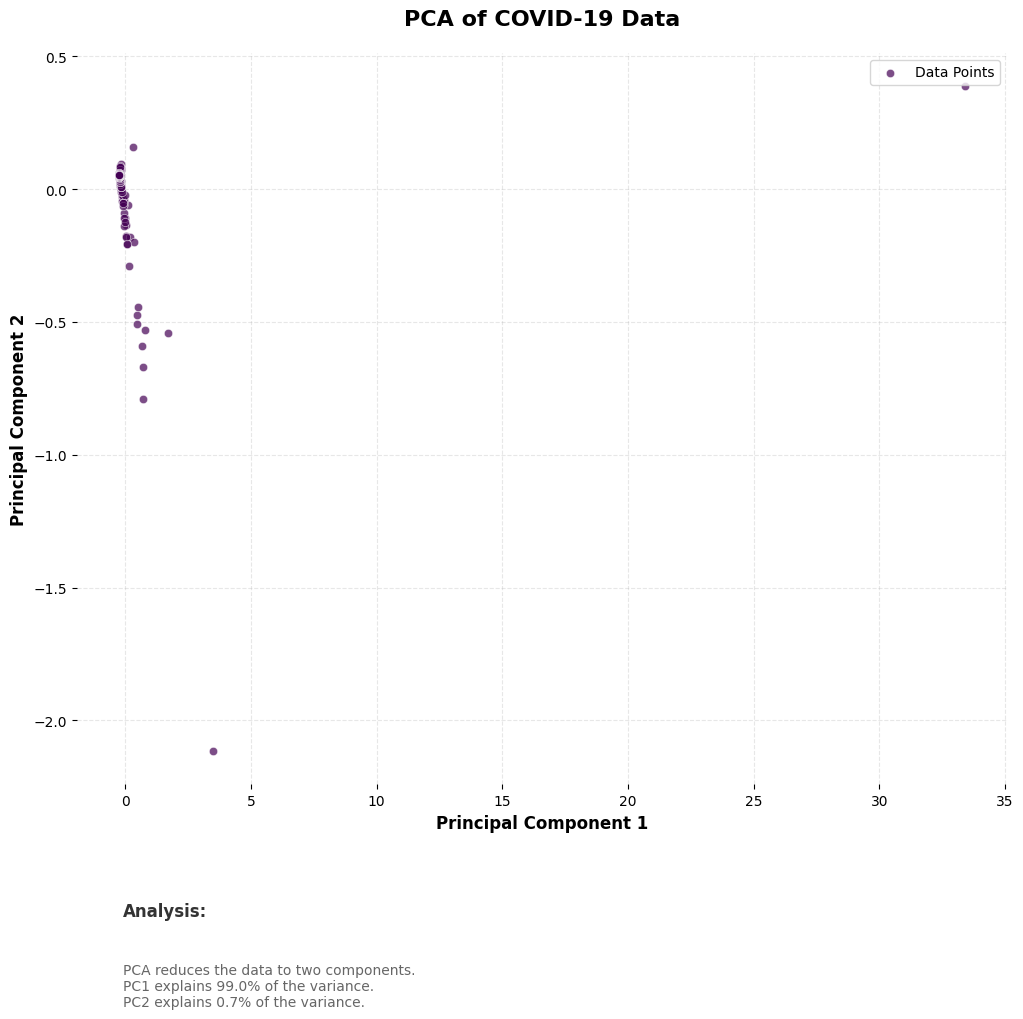

Explained variance ratio: [0.98971202 0.00710882]


In [12]:
pca_data = df_copy[cols_to_numeric].copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
fig, ax = plt.subplots(figsize=(12, 9.5)) # Increased figure height
fig.patch.set_facecolor('white')
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', data=pca_df, color=colors[0], alpha=0.7, ax=ax, label='Data Points')
ax.set_title('PCA of COVID-19 Data', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Principal Component 1', fontsize=12, fontweight='bold')
ax.set_ylabel('Principal Component 2', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend(loc='upper right', fontsize=10)  # Add legend
fig.text(0.05, -0.18, 'Analysis:', fontsize=12, fontweight='bold', color='#333', transform=ax.transAxes)  # Analysis text
analysis_text = (f"PCA reduces the data to two components.\n"
                 f"PC1 explains {pca.explained_variance_ratio_[0]*100:.1f}% of the variance.\n"
                 f"PC2 explains {pca.explained_variance_ratio_[1]*100:.1f}% of the variance.")
fig.text(0.05, -0.30, analysis_text, fontsize=10, color='#666', wrap=True, transform=ax.transAxes)  # Add specific analysis
plt.show()
print(f"Explained variance ratio: {pca.explained_variance_ratio_}") # Report explained variance

Mean Squared Error: 923474040.54
R-squared: 0.80


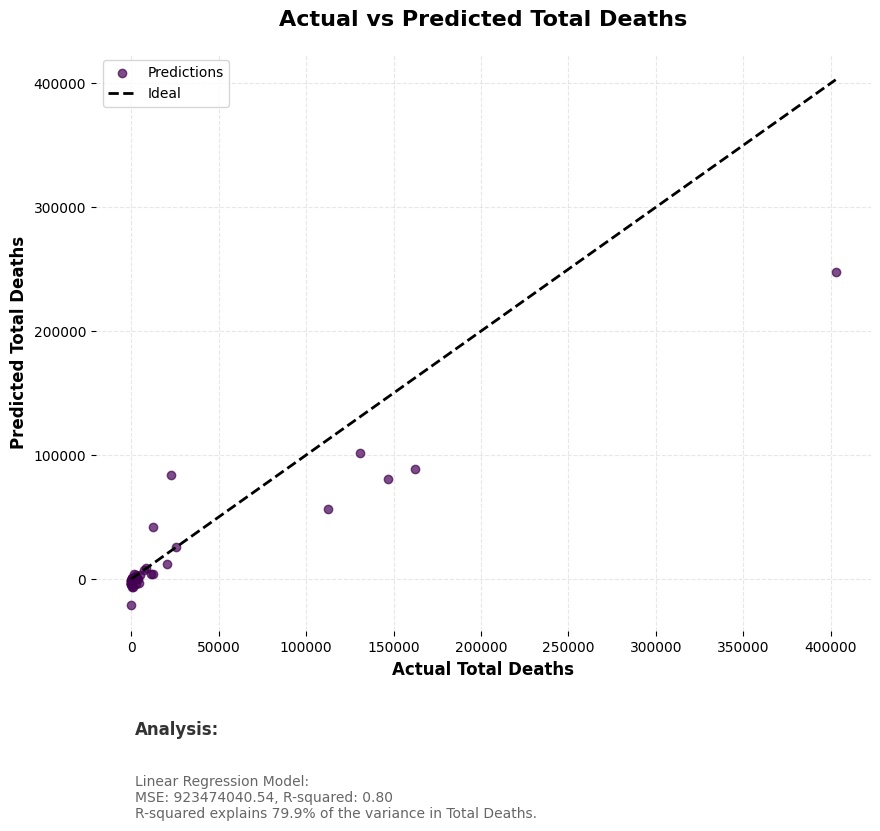

In [13]:
X = df_copy[['TotalCases', 'Population', 'Tests_per_1M']]  # features
y = df_copy['TotalDeaths']  # Target variable
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean()) # Impute missing values with the mean
y = y.replace([np.inf, -np.inf], np.nan)
y = y.fillna(y.mean())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
regression_analysis = (
    f"Linear Regression Model:\n"
    f"MSE: {mse:.2f}, R-squared: {r2:.2f}\n"
    f"R-squared explains {r2*100:.1f}% of the variance in Total Deaths."
)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")
fig, ax = plt.subplots(figsize=(10, 7.5))  # Increased figure height
fig.patch.set_facecolor('white')
ax.scatter(y_test, y_pred, color=colors[0], alpha=0.7, label='Predictions')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal') # Add a diagonal line
ax.set_xlabel('Actual Total Deaths', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Total Deaths', fontsize=12, fontweight='bold')
ax.set_title('Actual vs Predicted Total Deaths', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend(loc='upper left', fontsize=10)  # Add legend
fig.text(0.05, -0.18, 'Analysis:', fontsize=12, fontweight='bold', color='#333', transform=ax.transAxes)  # Analysis text
fig.text(0.05, -0.32, regression_analysis, fontsize=10, color='#666', wrap=True, transform=ax.transAxes)  # Add specific analysis
plt.show()